# Analyze survey

Let's look at coverage first.

In [98]:
%config InlineBackend.figure_format='retina'

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_survey = pd.read_csv('data/input/survey_clean.csv')
df_ccn = pd.read_csv('data/output/matches_with_annotations.csv')

df_survey = df_survey.iloc[4:]
df_survey = df_survey.rename(
    columns={'Name': 'name',
     'Notes': 'notes',
     'Which round are you in?': 'round',
     'Which table number were you at this round?': 'table',
     'How was your experience?': 'experience',
     'Was the thirty minute time limit adequate for each round?': 'time',
     'You were matched with other attendees based on your common interests. How well did your interests align?': 'align'
    }
)

align_map = {'Vaguely aligned': .5,
             'Exactly similar': 1.0,
             'Totally different': 0.0}
align_map_inv = {y:x for x, y in align_map.items()}
df_survey['align_score'] = df_survey['align'].map(lambda x: align_map[x])

df_ccn['round_table'] = df_ccn.apply(lambda x: f"{x['round']}_{x['group']}", axis=1)
df_survey['table'] = np.where(df_survey.table > 0, df_survey.table, 1)
df_survey['round_table'] = df_survey.apply(lambda x: f"{int(x['round'][6:])-1}_{int(x['table'])-1}", axis=1)

df = pd.merge(df_survey, df_ccn, left_on='round_table', right_on='round_table')

assert df.shape[0] == df_survey.shape[0]

print(f"Coverage: {100 * df_survey.shape[0] / df_ccn.shape[0] / 4:.1f}%")

Coverage: 64.2%


Very compliant audience! More than half filled out individual surveys. 

In [99]:
df_survey.align_score.value_counts()

0.5    175
1.0    117
0.0     24
Name: align_score, dtype: int64

In [100]:
df_survey.experience.value_counts()

5    180
4     93
3     32
2      8
1      3
Name: experience, dtype: int64

In [101]:
df_survey.experience.mean()

4.389240506329114

In [102]:
df_survey.groupby('round').experience.mean()

round
Round 1    4.465909
Round 2    4.425926
Round 3    4.300000
Name: experience, dtype: float64

Very good scores overall. Were our matching scores predictive of people's reactions to matches?

Text(40.08688868856838, 0.5, 'Alignment scored by participants')

<Figure size 1000x600 with 0 Axes>

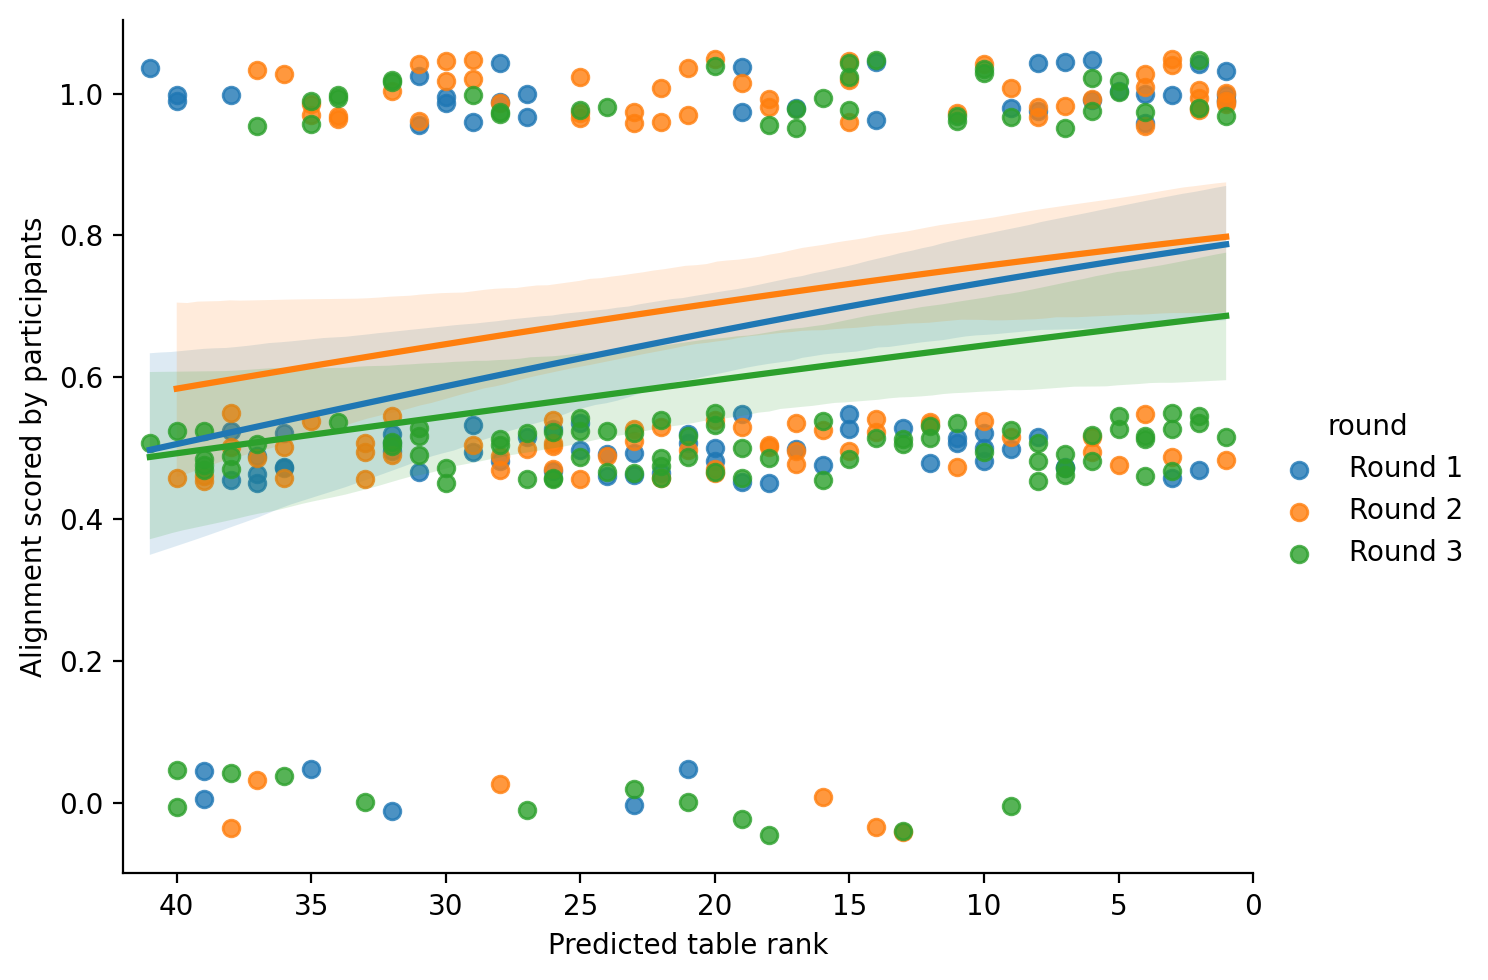

In [103]:
plt.figure(figsize=(10, 6))
sns.lmplot(data=df_survey, x='table', y='align_score', hue='round', y_jitter=.05, aspect=1.3, logistic=True)
plt.xlim((42, 0))
plt.xlabel('Predicted table rank')
plt.ylabel('Alignment scored by participants')

Text(40.08688868856838, 0.5, 'Alignment scored by participants')

<Figure size 1000x600 with 0 Axes>

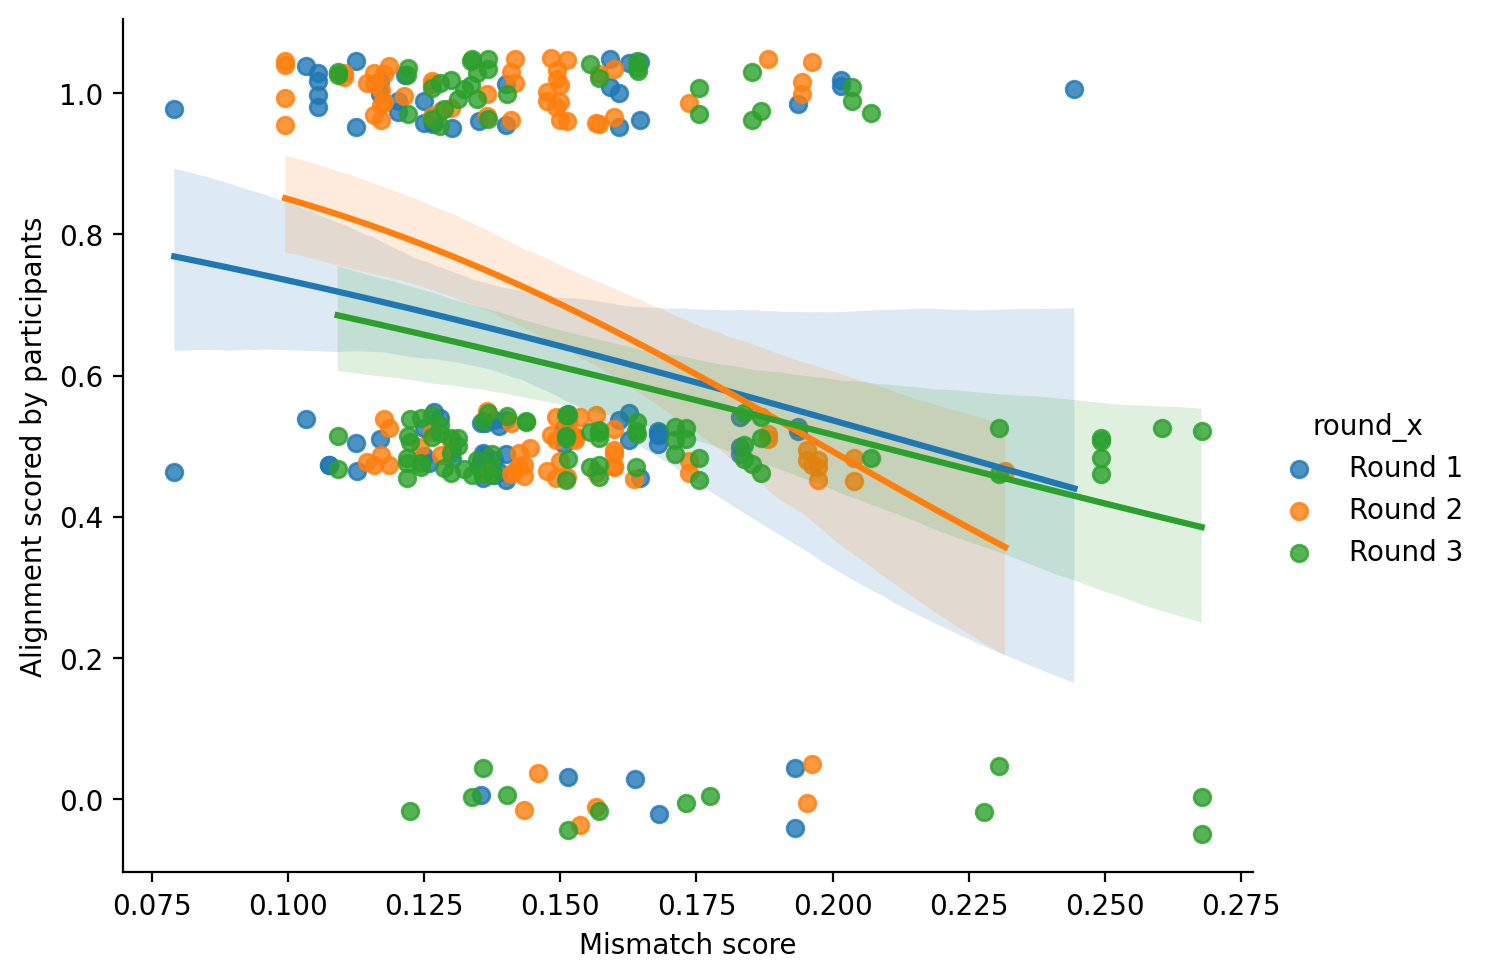

In [111]:
plt.figure(figsize=(10, 6))
sns.lmplot(data=df, x='mismatch_loss', y='align_score', hue='round_x', y_jitter=.05, aspect=1.3, logistic=True)
#plt.xlim((42, 0))
plt.xlabel('Mismatch score')
plt.ylabel('Alignment scored by participants')

Absolutely! A huge effect.

Text(39.92308760683761, 0.5, 'Alignment scored by participants')

<Figure size 1000x600 with 0 Axes>

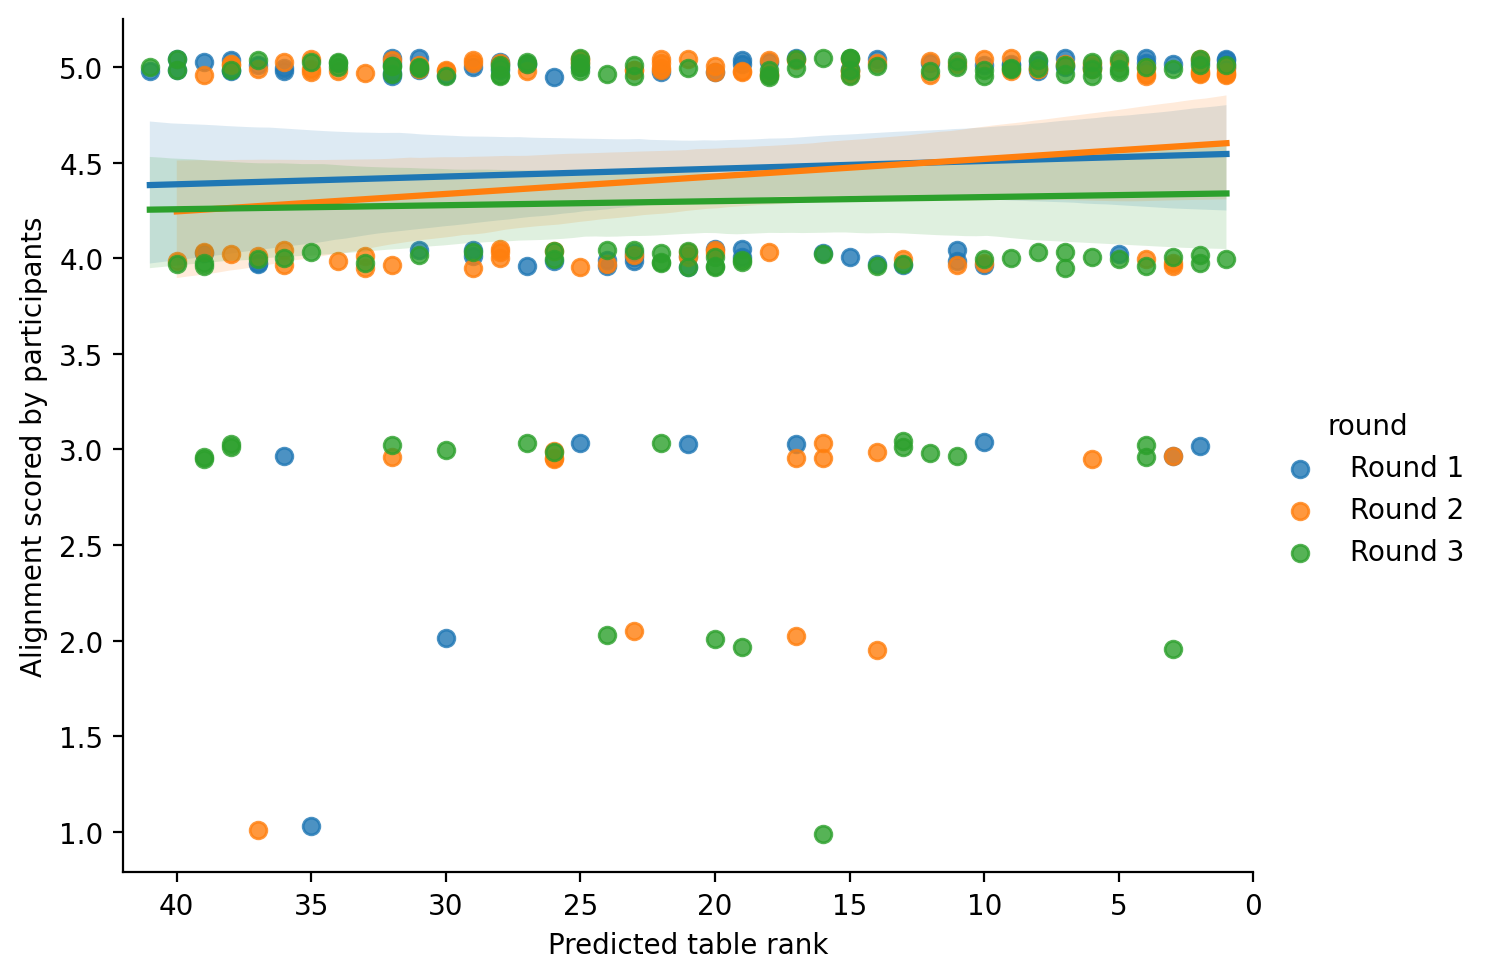

In [105]:
plt.figure(figsize=(10, 6))
sns.lmplot(data=df_survey, x='table', y='experience', hue='round', y_jitter=.05, aspect=1.3)
plt.xlim((42, 0))
plt.xlabel('Predicted table rank')
plt.ylabel('Alignment scored by participants')

Text(37.75998664529915, 0.5, 'Alignment scored by participants')

<Figure size 1000x600 with 0 Axes>

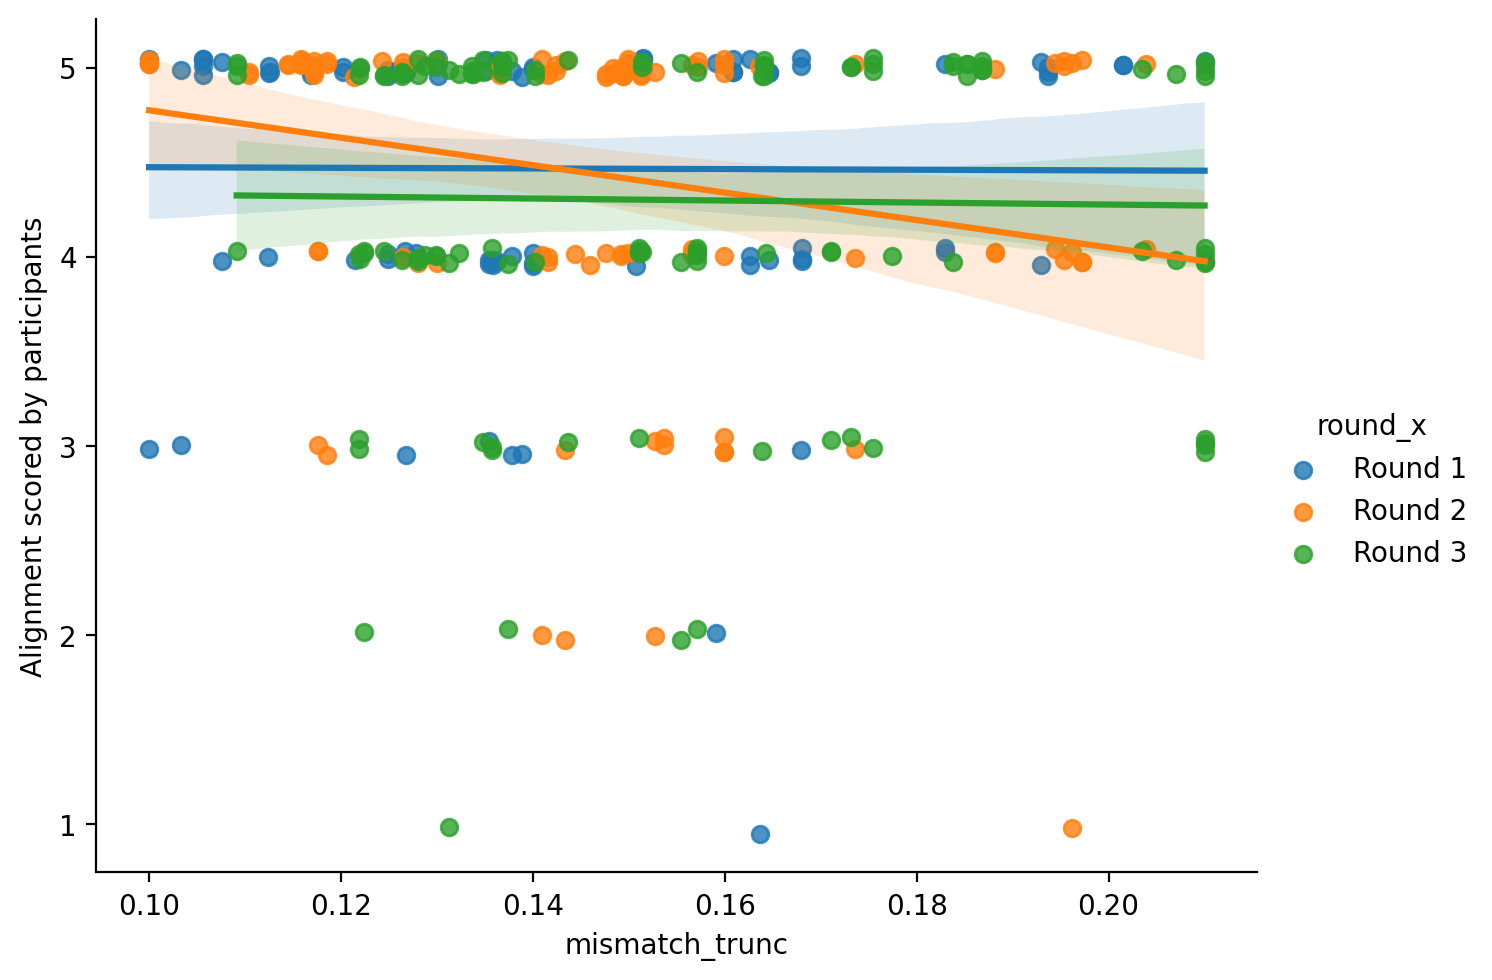

In [168]:
plt.figure(figsize=(10, 6))
df['mismatch_trunc'] = np.where(df.mismatch_loss.values < .21, df.mismatch_loss.values, .21)
df['mismatch_trunc'] = np.where(df.mismatch_trunc.values > .1, df.mismatch_trunc.values, .1)
sns.lmplot(data=df, x='mismatch_trunc', y='experience', hue='round_x', y_jitter=.05, aspect=1.3)
plt.ylabel('Alignment scored by participants')

A much smaller effect! The effect is most visible in round 2, which might be a question of logistics. Still, quality of alignment is a huge moderator of experience. Let's show that.

Text(0.5, 1.0, 'Covariation of alignment vs. satisfaction')

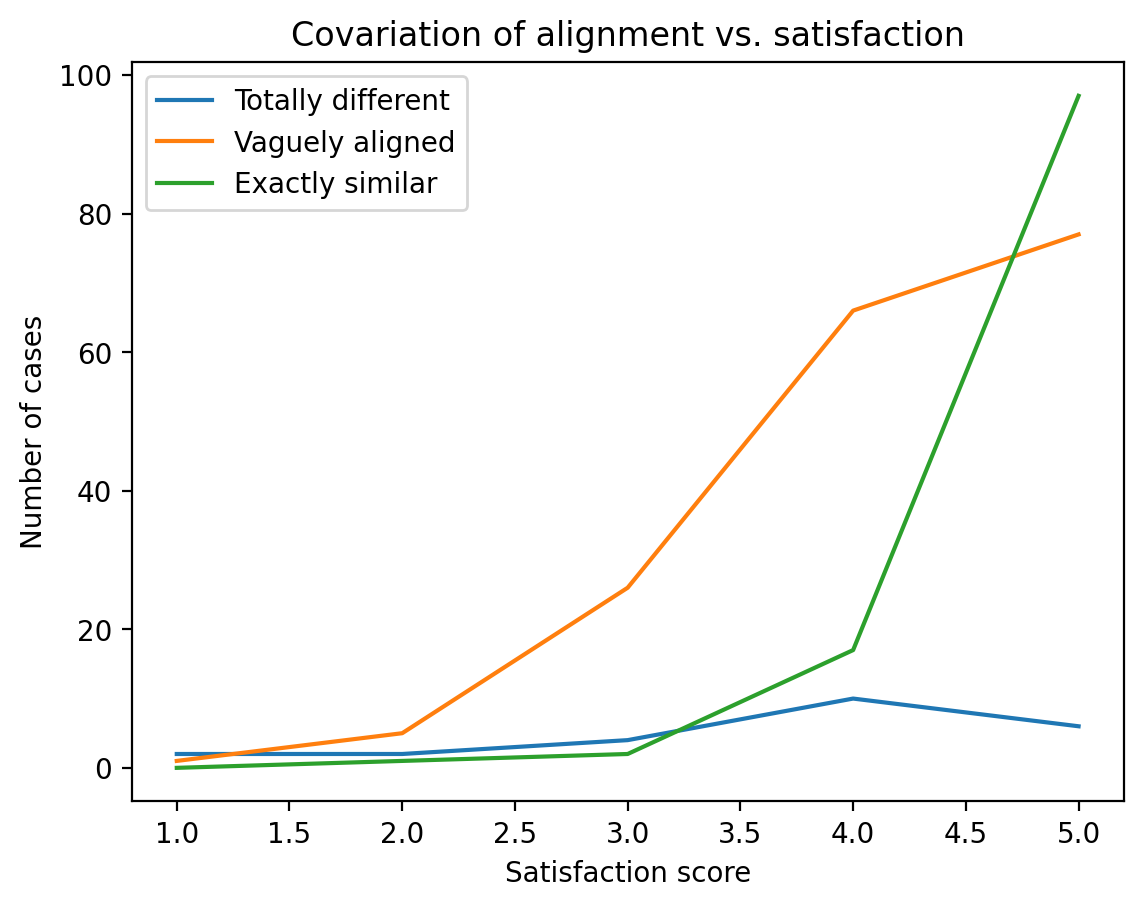

In [21]:
#Contigency map
import matplotlib.pyplot as plt

df_survey['num'] = 1
agg = df_survey.pivot_table('num', 'experience', 'align_score', aggfunc=np.sum).fillna(0)
agg.columns = agg.columns.map(lambda x: align_map_inv[x])
plt.plot(agg)
plt.legend(agg.columns)
plt.xlabel('Satisfaction score')
plt.ylabel('Number of cases')
plt.title('Covariation of alignment vs. satisfaction')

There's a pretty clear effect: the median satisfaction score is 5.0 when matches are rated as exactly similar ("a hit") while the median satisfaction is a 4.0 when they are rated as totally different. Let's calculate the mean effect.

In [19]:
df_survey.groupby('align').experience.mean()

align
Exactly similar      4.794872
Totally different    3.666667
Vaguely aligned      4.217143
Name: experience, dtype: float64

The maximum potential effect: goes from 3.7 stars (modestly satisfied) to 4.8 stars (wow! so satisfied!) going from unaligned to totally aligned.

Question: are good are random matches? How much better are we doing than random matching?

0.20453215


Text(0, 0.5, 'Instances')

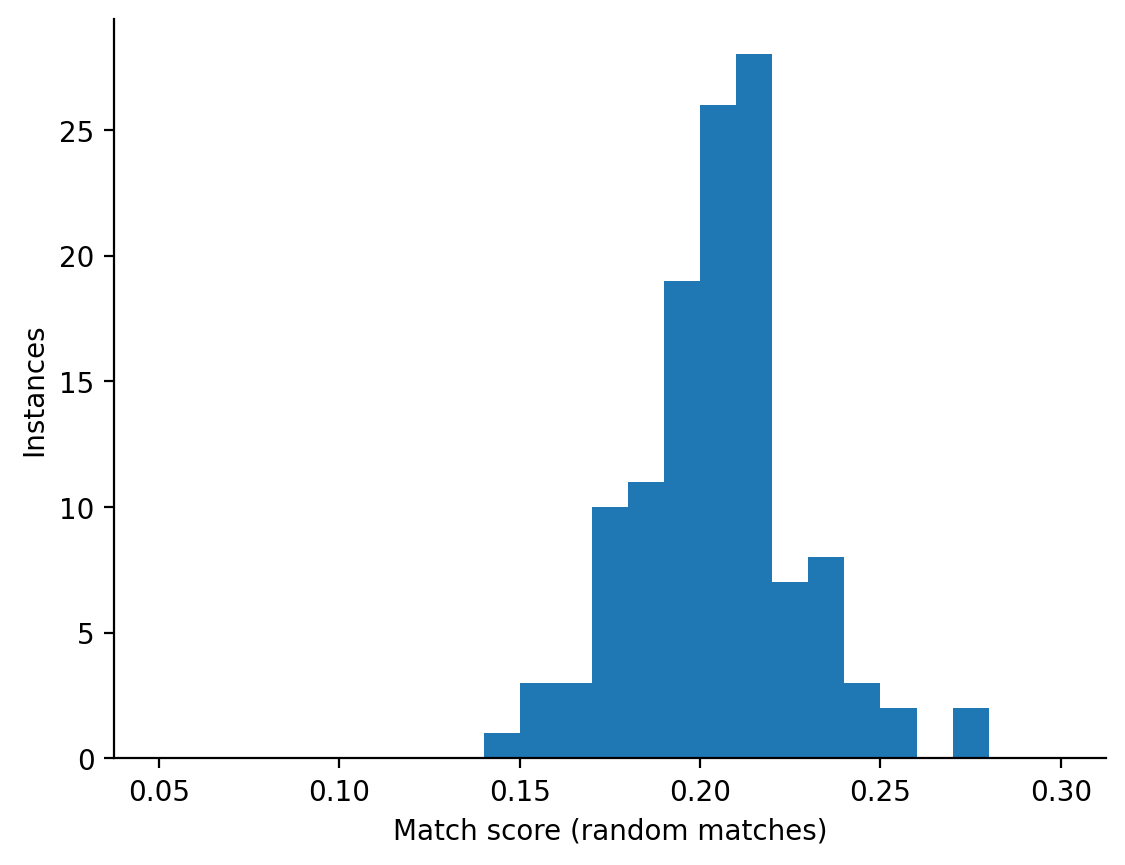

In [59]:
df_random_matches = pd.read_pickle('data/output/random_matches.pkl')
print(df_random_matches.goodness.mean())
plt.hist(df_random_matches.goodness, bins=np.linspace(.05, .3, 26))
ax = plt.gca()
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
plt.xlabel('Match score (random matches)')
plt.ylabel('Instances')

Text(0, 0.5, 'Instances')

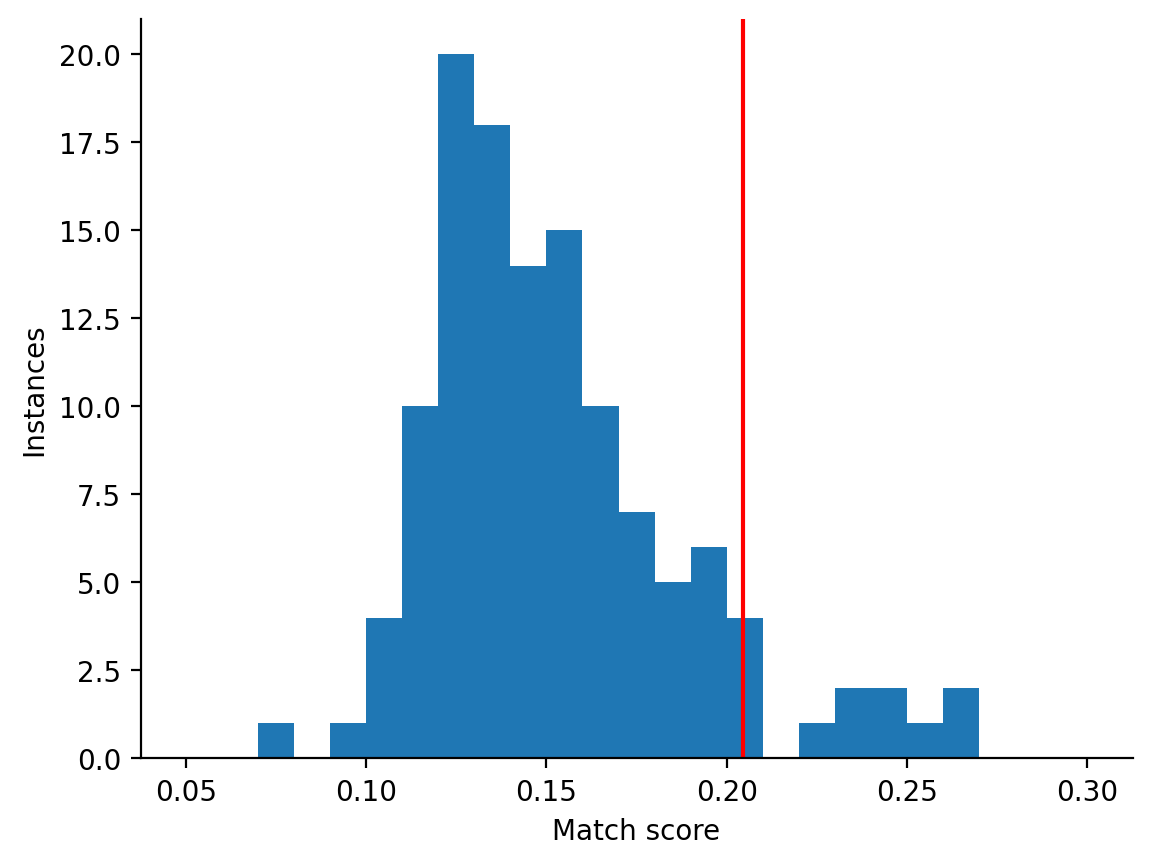

In [56]:
plt.hist(df_ccn.mismatch_loss, bins=np.linspace(.05, .3, 26))
rg = plt.ylim()
plt.vlines(x=df_random_matches.goodness.mean(), ymin=rg[0], ymax=rg[1], color='red')
plt.ylim(*rg)
# Hide the right and top spines
ax = plt.gca()
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
plt.xlabel('Match score')
plt.ylabel('Instances')

In [65]:
(df_random_matches.goodness.mean() - df_ccn.mismatch_loss.mean()) / df_ccn.mismatch_loss.std()

#df_random_matches.goodness.std()

1.4534016170625301

The matching algo creates a huge improvement in matching quality over a random matching baseline, equivalent to ~1.5 $\sigma$. Separate out by round.

<AxesSubplot:xlabel='mismatch_loss', ylabel='Count'>

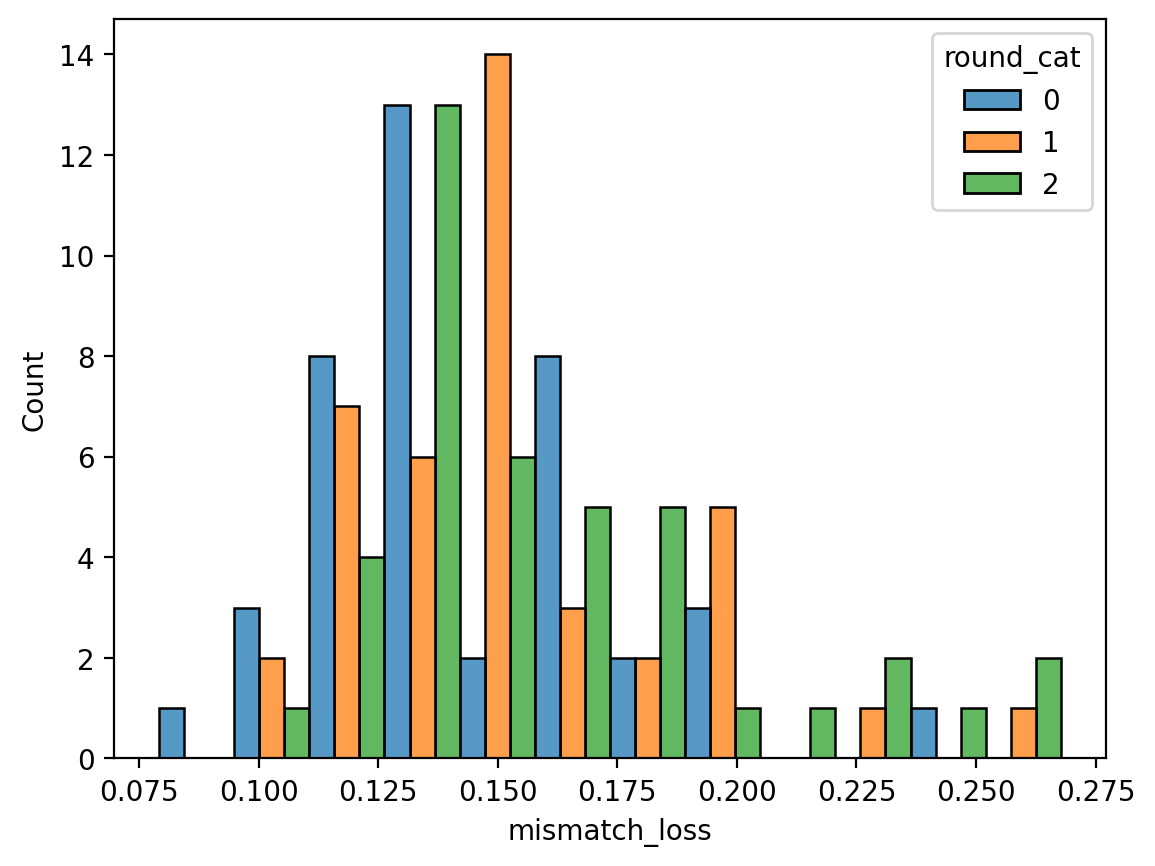

In [66]:
df_ccn['round_cat'] = df_ccn['round'].astype(str)
sns.histplot(data=df_ccn, x='mismatch_loss', hue='round_cat', multiple='dodge')

With all this prep-work, we can answer the question: how much better are we doing than doing random matches?

In [172]:
df.logistics_issues

0          NaN
1          NaN
2      checked
3          NaN
4          NaN
        ...   
311    checked
312    checked
313        NaN
314        NaN
315        NaN
Name: logistics_issues, Length: 316, dtype: object

In [192]:
import statsmodels
#import statsmodels.genmod.families.family.Family
import statsmodels.formula.api as smf

df['experience_01'] = df.experience / 5.0
df['mismatch_trunc_centered'] = df['mismatch_trunc'] - .15
df['reported_logistics_issue'] = ~df['logistics_issues'].isna()

clf = smf.glm('experience_01 ~ mismatch_trunc_centered + reported_logistics_issue', data=df, family=statsmodels.genmod.families.family.Binomial())
results = clf.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          experience_01   No. Observations:                  316
Model:                            GLM   Df Residuals:                      313
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -92.503
Date:                Fri, 02 Sep 2022   Deviance:                       83.705
Time:                        16:23:52   Pearson chi2:                     82.1
No. Iterations:                     5   Pseudo R-squ. (CS):           0.003063
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            1.9893      0.176     11.311      0.000       1.645       2.334
reported_logistics_issue[T.True]    -0.4161      0.893     -0.466      0.641      -2.166       1.333
mismatch_trunc_centered             -5.1231      5.956     -0.860      0.390     -16.796       6.550
====================================================================================================
"""

In [197]:
logistic = lambda x: 1 / (1 + np.exp(-x))
preds_some = logistic(results.params.mismatch_trunc_centered * df.mismatch_trunc_centered + results.params.Intercept)
preds_none = logistic(results.params.mismatch_trunc_centered * (df_random_matches.goodness - .15) + results.params.Intercept)

preds_some.mean() - preds_none.mean()

0.033130123705068515

In [202]:
import statsmodels
#import statsmodels.genmod.families.family.Family
import statsmodels.formula.api as smf

df['experience_01'] = df.experience / 5.0
df['mismatch_trunc_centered'] = df['mismatch_trunc'] - .15
df['reported_logistics_issue'] = ~df['logistics_issues'].isna()

clf = smf.glm('align_score ~ mismatch_trunc_centered', data=df, family=statsmodels.genmod.families.family.Binomial())
results = clf.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            align_score   No. Observations:                  316
Model:                            GLM   Df Residuals:                      314
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -158.63
Date:                Fri, 02 Sep 2022   Deviance:                       159.21
Time:                        16:27:27   Pearson chi2:                     119.
No. Iterations:                     4   Pseudo R-squ. (CS):            0.02646
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.6103      0.120      5.107      0.000       0.376       0.845
mismatch_trunc_centered   -12.1716      4.218     -2.886      0.004     -20.438      -3.905
===========================================================================================
"""